# Tutorial Notebook

This notebook will go over how to work with the Heart class to analyze *Drosophila* hearts

In [1]:
# important libraries 
import FlyHeart
import pickle

# for demonstration
import matplotlib.pyplot as plt
import time as t

/home/ymelkani/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
example_video_path = "./example_videos/CS_1wm_58_C11440_30s.avi"

#create a heart object
heart = FlyHeart.Heart(example_video_path, recording_fps = 200,  um_to_px = 1.5325, num_frames = 2000, save_folder = "./results/")

# create a confidence map of where the heart is for each frame
t0 = t.time()
heart.annotate()
print(f"Finished predicting with 2000 frames in {t.time() - t0}s")

Finished predicting with 2000 frames in 36.06238603591919s


Let's take a look at what the confidence maps look like

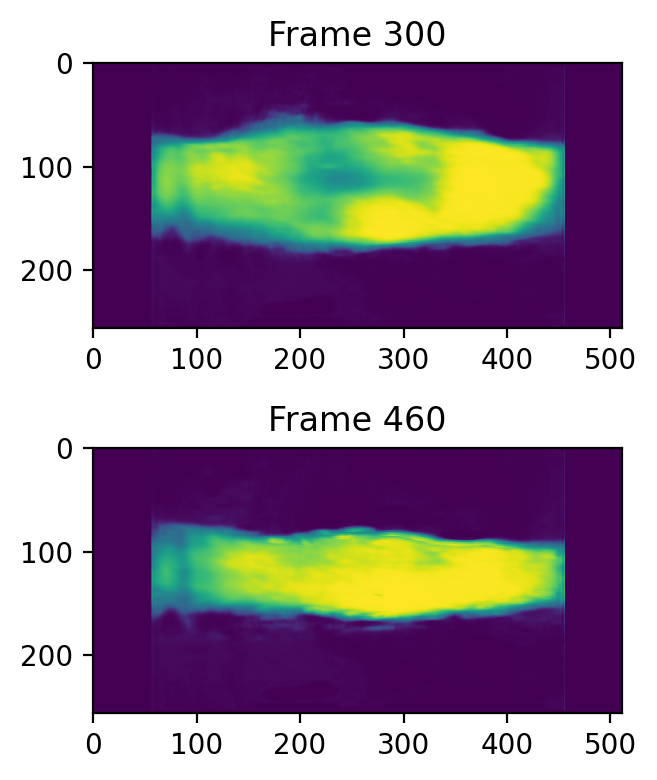

In [4]:
fig, axes = plt.subplots(2, 1, dpi = 200)

axes[0].imshow(heart.confidence_maps[300, :, :])
axes[0].set_title("Frame 300")

axes[1].imshow(heart.confidence_maps[460, :, :])
axes[1].set_title("Frame 460")

plt.tight_layout()
plt.show()

Now let's find a suitable roi and threshold to use 

In [5]:
%matplotlib inline

from ipywidgets import interactive, widgets
import matplotlib.pyplot as plt
import numpy as np

def plot(thresh, frame, roi):
    img = heart.frames[frame, :, :]
    mask = heart.confidence_maps[frame]>thresh
    plt.figure(figsize = (7,3.5), dpi = 150)
    plt.imshow(img, cmap = 'gray')
    masked = np.ma.masked_where(mask == 0, mask)
    plt.imshow(masked, alpha = 0.2, cmap = 'autumn')
    plt.axvline(x=roi[0])
    plt.axvline(x=roi[1])
    plt.show()
    
Thresh_slider = widgets.FloatSlider(value=0.375, min=0, max=0.99, step=.025, description="Confidence")
ROI_slider = widgets.IntRangeSlider(
        value = (125, 375),
        min=0,
        max=512,
        step=1,
        description='ROI:',
        continuous_update=False,
        orientation='horizontal',
        readout=True,
)
Frame_slider = widgets.IntSlider(value=100, min=0, max=1999, step=1, description="frame")

interactive(plot, 
            thresh=Thresh_slider,
            frame = Frame_slider,
            roi = ROI_slider)

interactive(children=(FloatSlider(value=0.375, description='Confidence', max=0.99, step=0.025), IntSlider(valu…

Once we've selected a good threshold and roi, we can call the get_timeseries() to calculate the average diameter of the heart (as well as other metrics) for each frame. After that, we call the calculate_parameters() method to produce cardiac parameters of the heart. 

The results of both methods are saved internally in the Heart object and are also returned by their respective method call.

In [6]:
thresh = Thresh_slider.value
roi = ROI_slider.value

heart.get_timeseries(roi = roi, confidence_thresh = thresh)
heart.calculate_parameters()

print("Spatial Parameters:")
print("DD: ", heart.params["DD"]["avg"])
print("SD: ", heart.params["SD"]["avg"])
print("FS: ", heart.params["FS"]["avg"])
print("EF: ", heart.params["EF"]["avg"])

print()
print("Temporal Parameters:")
print("DI: ", heart.params["DI"]["avg"])
print("SI: ", heart.params["SI"]["avg"])
print("HP: ", heart.params["HP"]["avg"])
print("HR: ", heart.params["HR"]["avg"])
print("AI: ", heart.params["AI"]["val"])


Spatial Parameters:
DD:  74.60017090033402
SD:  46.3083849918434
FS:  0.37921853188599297
EF:  0.6146212635449932

Temporal Parameters:
DI:  0.6200000000000001
SI:  0.29000000000000004
HP:  0.907
HR:  1.1025358324145533
AI:  0.1868710133307697


/data/project/Drosophila_MelkaniLab/YASH/Public Release/Heart Analysis/FlyHeart.py:170: RuntimeWarning: invalid value encountered in true_divide
  X = (X - np.min(X)) / (np.max(X) - np.min(X))


We can finally save our Heart objects now! To do this, we simply call heart.save(). This will save the following into our save folder:

- The heart object itself
- A text file with some useful information about our heart object
- A csv of timeseries data (such as the Average Diameter and Area)

You can also change the save folder by specifying the new directory in the save() method. This will save everything in the new directory

In [7]:
heart.save()

In order to read the heart object again for later use, we can just load the file with pickle

In [8]:
file = open(f'results/CS_1wm_58_C11440_30s/CS_1wm_58_C11440_30s.heart', "rb")
heart = pickle.load(file)